In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data/bioimaging/train/'
test_dir = "data/bioimaging/test/"

extracted_features_dir = "extracted_features/"
model_name = "bioimaging_vgg19"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.9.0
dim_ordering: tf


In [5]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/bioimaging/train/ 0
data/bioimaging/train/carcinoma 5696
data/bioimaging/train/non-carcinoma 5696
******************************
data/bioimaging/test/ 0
data/bioimaging/test/carcinoma 36
data/bioimaging/test/non-carcinoma 35


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 8544 images belonging to 2 classes.
Found 2848 images belonging to 2 classes.
Found 71 images belonging to 2 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 8544
nb_validation_samples: 2848

predict_size_train: 267
predict_size_validation: 89
nb_test_samples: 71
predict_size_test: 3

 num_classes: 2


In [9]:
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

#     config = tf.ConfigProto()
#     config.gpu_options.allow_growth = True
#     set_session(tf.Session(config=config))


reset_keras_tf_session()

In [33]:
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.densenet import DenseNet169
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetMobile

input_tensor = Input(shape = input_shape)  
model = VGG19(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=input_tensor)

In [34]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_2
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool
22 global_average_pooling2d_2


In [35]:
c1 = model.layers[4].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[7].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[12].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[17].output
c4 = GlobalAveragePooling2D()(c4)

con = concatenate([c1, c2, c4])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [36]:
bottleneck_final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [37]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [38]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [39]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [40]:
dropout_rate = 0.4

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.9, amsgrad=False)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 8544 samples, validate on 2848 samples
Epoch 1/1000
 - 1s - loss: 0.6708 - acc: 0.6901 - val_loss: 0.4374 - val_acc: 0.7932
Epoch 2/1000
 - 1s - loss: 0.4482 - acc: 0.7883 - val_loss: 0.3917 - val_acc: 0.8195
Epoch 3/1000
 - 1s - loss: 0.3954 - acc: 0.8201 - val_loss: 0.3434 - val_acc: 0.8676
Epoch 4/1000
 - 1s - loss: 0.3546 - acc: 0.8394 - val_loss: 0.3188 - val_acc: 0.8757
Epoch 5/1000
 - 1s - loss: 0.3210 - acc: 0.8615 - val_loss: 0.2811 - val_acc: 0.8940
Epoch 6/1000
 - 1s - loss: 0.2896 - acc: 0.8825 - val_loss: 0.2631 - val_acc: 0.8999
Epoch 7/1000
 - 1s - loss: 0.2652 - acc: 0.8955 - val_loss: 0.2684 - val_acc: 0.8838
Epoch 8/1000
 - 1s - loss: 0.2416 - acc: 0.9059 - val_loss: 0.2296 - val_acc: 0.9055
Epoch 9/1000
 - 1s - loss: 0.2175 - acc: 0.9161 - val_loss: 0.1917 - val_acc: 0.9354
Epoch 10/1000
 - 1s - loss: 0.1966 - acc: 0.9258 - val_loss: 0.1786 - val_acc: 0.9435
Epoch 11/1000
 - 1s - loss: 0.1781 - acc: 0.9320 - val_loss: 0.1727 - val_acc: 0.9361
Epoch 12/1000
 

Epoch 96/1000
 - 1s - loss: 0.0081 - acc: 0.9973 - val_loss: 0.0126 - val_acc: 0.9951
Epoch 97/1000
 - 1s - loss: 0.0090 - acc: 0.9973 - val_loss: 0.0179 - val_acc: 0.9930
Epoch 98/1000
 - 1s - loss: 0.0101 - acc: 0.9964 - val_loss: 0.0101 - val_acc: 0.9972
Epoch 99/1000
 - 1s - loss: 0.0077 - acc: 0.9978 - val_loss: 0.0123 - val_acc: 0.9947
Epoch 100/1000
 - 1s - loss: 0.0083 - acc: 0.9975 - val_loss: 0.0095 - val_acc: 0.9961
Epoch 101/1000
 - 1s - loss: 0.0087 - acc: 0.9967 - val_loss: 0.0166 - val_acc: 0.9933
Epoch 102/1000
 - 1s - loss: 0.0089 - acc: 0.9975 - val_loss: 0.0108 - val_acc: 0.9951
Epoch 103/1000
 - 1s - loss: 0.0072 - acc: 0.9978 - val_loss: 0.0125 - val_acc: 0.9944
Epoch 104/1000
 - 1s - loss: 0.0083 - acc: 0.9973 - val_loss: 0.0182 - val_acc: 0.9940
Epoch 105/1000
 - 1s - loss: 0.0079 - acc: 0.9972 - val_loss: 0.0180 - val_acc: 0.9933
Epoch 106/1000
 - 1s - loss: 0.0073 - acc: 0.9978 - val_loss: 0.0102 - val_acc: 0.9961
Epoch 107/1000
 - 1s - loss: 0.0076 - acc: 0.99

Epoch 191/1000
 - 1s - loss: 0.0043 - acc: 0.9984 - val_loss: 0.0155 - val_acc: 0.9954
Epoch 192/1000
 - 1s - loss: 0.0051 - acc: 0.9979 - val_loss: 0.0145 - val_acc: 0.9954
Epoch 193/1000
 - 1s - loss: 0.0040 - acc: 0.9986 - val_loss: 0.0059 - val_acc: 0.9968
Epoch 194/1000
 - 1s - loss: 0.0054 - acc: 0.9979 - val_loss: 0.0076 - val_acc: 0.9961
Epoch 195/1000
 - 1s - loss: 0.0057 - acc: 0.9979 - val_loss: 0.0166 - val_acc: 0.9951
Epoch 196/1000
 - 1s - loss: 0.0034 - acc: 0.9988 - val_loss: 0.0231 - val_acc: 0.9933
Epoch 197/1000
 - 1s - loss: 0.0049 - acc: 0.9985 - val_loss: 0.0070 - val_acc: 0.9972
Epoch 198/1000
 - 1s - loss: 0.0019 - acc: 0.9995 - val_loss: 0.0141 - val_acc: 0.9958
Epoch 199/1000
 - 1s - loss: 0.0052 - acc: 0.9982 - val_loss: 0.0140 - val_acc: 0.9954
Epoch 200/1000
 - 1s - loss: 0.0037 - acc: 0.9988 - val_loss: 0.0095 - val_acc: 0.9954
Epoch 201/1000
 - 1s - loss: 0.0058 - acc: 0.9982 - val_loss: 0.0173 - val_acc: 0.9937
Epoch 202/1000
 - 1s - loss: 0.0041 - acc: 

 - 1s - loss: 0.0042 - acc: 0.9987 - val_loss: 0.0046 - val_acc: 0.9972
Epoch 286/1000
 - 1s - loss: 0.0028 - acc: 0.9991 - val_loss: 0.0085 - val_acc: 0.9965
Epoch 287/1000
 - 1s - loss: 0.0030 - acc: 0.9987 - val_loss: 0.0155 - val_acc: 0.9951
Epoch 288/1000
 - 1s - loss: 0.0020 - acc: 0.9989 - val_loss: 0.0198 - val_acc: 0.9937
Epoch 289/1000
 - 1s - loss: 0.0049 - acc: 0.9981 - val_loss: 0.0043 - val_acc: 0.9986
Epoch 290/1000
 - 1s - loss: 0.0032 - acc: 0.9991 - val_loss: 0.0057 - val_acc: 0.9975
Epoch 291/1000
 - 1s - loss: 0.0031 - acc: 0.9987 - val_loss: 0.0225 - val_acc: 0.9937
Epoch 292/1000
 - 1s - loss: 0.0021 - acc: 0.9993 - val_loss: 0.0077 - val_acc: 0.9975
Epoch 293/1000
 - 1s - loss: 0.0023 - acc: 0.9991 - val_loss: 0.0051 - val_acc: 0.9972
Epoch 294/1000
 - 1s - loss: 0.0026 - acc: 0.9995 - val_loss: 0.0059 - val_acc: 0.9975
Epoch 295/1000
 - 1s - loss: 0.0020 - acc: 0.9995 - val_loss: 0.0076 - val_acc: 0.9979
Epoch 296/1000
 - 1s - loss: 0.0042 - acc: 0.9981 - val_lo

Epoch 380/1000
 - 1s - loss: 0.0017 - acc: 0.9996 - val_loss: 0.0207 - val_acc: 0.9944
Epoch 381/1000
 - 1s - loss: 0.0021 - acc: 0.9991 - val_loss: 0.0047 - val_acc: 0.9975
Epoch 382/1000
 - 1s - loss: 0.0028 - acc: 0.9988 - val_loss: 0.0083 - val_acc: 0.9965
Epoch 383/1000
 - 1s - loss: 0.0020 - acc: 0.9996 - val_loss: 0.0053 - val_acc: 0.9982
Epoch 384/1000
 - 1s - loss: 0.0031 - acc: 0.9989 - val_loss: 0.0113 - val_acc: 0.9968
Epoch 385/1000
 - 1s - loss: 0.0031 - acc: 0.9989 - val_loss: 0.0048 - val_acc: 0.9979
Epoch 386/1000
 - 1s - loss: 0.0020 - acc: 0.9992 - val_loss: 0.0041 - val_acc: 0.9979
Epoch 387/1000
 - 1s - loss: 0.0034 - acc: 0.9993 - val_loss: 0.0093 - val_acc: 0.9965
Epoch 388/1000
 - 1s - loss: 0.0026 - acc: 0.9994 - val_loss: 0.0123 - val_acc: 0.9958
Epoch 389/1000
 - 1s - loss: 0.0019 - acc: 0.9993 - val_loss: 0.0083 - val_acc: 0.9968
Epoch 390/1000
 - 1s - loss: 0.0033 - acc: 0.9988 - val_loss: 0.0156 - val_acc: 0.9951
Epoch 391/1000
 - 1s - loss: 0.0029 - acc: 

Epoch 474/1000
 - 1s - loss: 0.0014 - acc: 0.9993 - val_loss: 0.0089 - val_acc: 0.9972
Epoch 475/1000
 - 1s - loss: 0.0050 - acc: 0.9981 - val_loss: 0.0092 - val_acc: 0.9965
Epoch 476/1000
 - 1s - loss: 0.0023 - acc: 0.9995 - val_loss: 0.0286 - val_acc: 0.9916
Epoch 477/1000
 - 1s - loss: 0.0014 - acc: 0.9995 - val_loss: 0.0109 - val_acc: 0.9961
Epoch 478/1000
 - 1s - loss: 0.0024 - acc: 0.9992 - val_loss: 0.0088 - val_acc: 0.9975
Epoch 479/1000
 - 1s - loss: 0.0013 - acc: 0.9995 - val_loss: 0.0068 - val_acc: 0.9975
Epoch 480/1000
 - 1s - loss: 0.0030 - acc: 0.9989 - val_loss: 0.0060 - val_acc: 0.9986
Epoch 481/1000
 - 1s - loss: 0.0022 - acc: 0.9993 - val_loss: 0.0152 - val_acc: 0.9954
Epoch 482/1000
 - 1s - loss: 0.0032 - acc: 0.9992 - val_loss: 0.0026 - val_acc: 0.9989
Epoch 483/1000
 - 1s - loss: 0.0017 - acc: 0.9993 - val_loss: 0.0096 - val_acc: 0.9968
Epoch 484/1000
 - 1s - loss: 0.0028 - acc: 0.9992 - val_loss: 0.0051 - val_acc: 0.9979
Epoch 485/1000
 - 1s - loss: 9.2490e-04 - a

Epoch 568/1000
 - 1s - loss: 0.0014 - acc: 0.9994 - val_loss: 0.0054 - val_acc: 0.9982
Epoch 569/1000
 - 1s - loss: 0.0028 - acc: 0.9988 - val_loss: 0.0031 - val_acc: 0.9989
Epoch 570/1000
 - 1s - loss: 0.0016 - acc: 0.9995 - val_loss: 0.0173 - val_acc: 0.9958
Epoch 571/1000
 - 1s - loss: 0.0021 - acc: 0.9992 - val_loss: 0.0059 - val_acc: 0.9975
Epoch 572/1000
 - 1s - loss: 0.0014 - acc: 0.9996 - val_loss: 0.0076 - val_acc: 0.9979
Epoch 573/1000
 - 1s - loss: 7.5535e-04 - acc: 0.9998 - val_loss: 0.0069 - val_acc: 0.9986
Epoch 574/1000
 - 1s - loss: 0.0051 - acc: 0.9985 - val_loss: 0.0105 - val_acc: 0.9975
Epoch 575/1000
 - 1s - loss: 9.2525e-04 - acc: 0.9996 - val_loss: 0.0130 - val_acc: 0.9958
Epoch 576/1000
 - 1s - loss: 0.0014 - acc: 0.9992 - val_loss: 0.0092 - val_acc: 0.9972
Epoch 577/1000
 - 1s - loss: 0.0043 - acc: 0.9986 - val_loss: 0.0334 - val_acc: 0.9902
Epoch 578/1000
 - 1s - loss: 0.0026 - acc: 0.9993 - val_loss: 0.0076 - val_acc: 0.9975
Epoch 579/1000
 - 1s - loss: 0.0033

Epoch 662/1000
 - 1s - loss: 0.0014 - acc: 0.9996 - val_loss: 0.0084 - val_acc: 0.9979
Epoch 663/1000
 - 1s - loss: 0.0020 - acc: 0.9995 - val_loss: 0.0146 - val_acc: 0.9961
Epoch 664/1000
 - 1s - loss: 4.8225e-04 - acc: 0.9998 - val_loss: 0.0107 - val_acc: 0.9968
Epoch 665/1000
 - 1s - loss: 0.0025 - acc: 0.9993 - val_loss: 0.0037 - val_acc: 0.9982
Epoch 666/1000
 - 1s - loss: 0.0018 - acc: 0.9995 - val_loss: 0.0078 - val_acc: 0.9968
Epoch 667/1000
 - 1s - loss: 0.0017 - acc: 0.9995 - val_loss: 0.0036 - val_acc: 0.9986
Epoch 668/1000
 - 1s - loss: 7.3680e-04 - acc: 0.9996 - val_loss: 0.0070 - val_acc: 0.9972
Epoch 669/1000
 - 1s - loss: 0.0040 - acc: 0.9988 - val_loss: 0.0046 - val_acc: 0.9982
Epoch 670/1000
 - 1s - loss: 0.0013 - acc: 0.9994 - val_loss: 0.0047 - val_acc: 0.9979
Epoch 671/1000
 - 1s - loss: 0.0029 - acc: 0.9991 - val_loss: 0.0127 - val_acc: 0.9961
Epoch 672/1000
 - 1s - loss: 0.0011 - acc: 0.9996 - val_loss: 0.0110 - val_acc: 0.9965
Epoch 673/1000
 - 1s - loss: 0.0027

Epoch 756/1000
 - 1s - loss: 0.0015 - acc: 0.9995 - val_loss: 0.0066 - val_acc: 0.9979
Epoch 757/1000
 - 1s - loss: 0.0011 - acc: 0.9995 - val_loss: 0.0036 - val_acc: 0.9989
Epoch 758/1000
 - 1s - loss: 0.0018 - acc: 0.9994 - val_loss: 0.0216 - val_acc: 0.9944
Epoch 759/1000
 - 1s - loss: 0.0029 - acc: 0.9991 - val_loss: 0.0111 - val_acc: 0.9965
Epoch 760/1000
 - 1s - loss: 0.0011 - acc: 0.9994 - val_loss: 0.0056 - val_acc: 0.9979
Epoch 761/1000
 - 1s - loss: 0.0014 - acc: 0.9995 - val_loss: 0.0151 - val_acc: 0.9958
Epoch 762/1000
 - 1s - loss: 5.6198e-04 - acc: 0.9998 - val_loss: 0.0086 - val_acc: 0.9975
Epoch 763/1000
 - 1s - loss: 0.0022 - acc: 0.9995 - val_loss: 0.0033 - val_acc: 0.9993
Epoch 764/1000
 - 1s - loss: 0.0020 - acc: 0.9995 - val_loss: 0.0056 - val_acc: 0.9989
Epoch 765/1000
 - 1s - loss: 0.0032 - acc: 0.9991 - val_loss: 0.0106 - val_acc: 0.9968
Epoch 766/1000
 - 1s - loss: 0.0016 - acc: 0.9992 - val_loss: 0.0089 - val_acc: 0.9972
Epoch 767/1000
 - 1s - loss: 0.0042 - a

 - 1s - loss: 0.0054 - acc: 0.9986 - val_loss: 0.0039 - val_acc: 0.9986
Epoch 850/1000
 - 1s - loss: 2.6720e-04 - acc: 0.9999 - val_loss: 0.0123 - val_acc: 0.9965
Epoch 851/1000
 - 1s - loss: 0.0037 - acc: 0.9992 - val_loss: 0.0414 - val_acc: 0.9912
Epoch 852/1000
 - 1s - loss: 0.0014 - acc: 0.9995 - val_loss: 0.0086 - val_acc: 0.9968
Epoch 853/1000
 - 1s - loss: 0.0023 - acc: 0.9995 - val_loss: 0.0162 - val_acc: 0.9968
Epoch 854/1000
 - 1s - loss: 0.0041 - acc: 0.9991 - val_loss: 0.0066 - val_acc: 0.9975
Epoch 855/1000
 - 1s - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0045 - val_acc: 0.9979
Epoch 856/1000
 - 1s - loss: 0.0017 - acc: 0.9995 - val_loss: 0.0128 - val_acc: 0.9965
Epoch 857/1000
 - 1s - loss: 0.0015 - acc: 0.9992 - val_loss: 0.0015 - val_acc: 0.9989
Epoch 858/1000
 - 1s - loss: 0.0013 - acc: 0.9995 - val_loss: 0.0093 - val_acc: 0.9979
Epoch 859/1000
 - 1s - loss: 0.0015 - acc: 0.9996 - val_loss: 0.0120 - val_acc: 0.9972
Epoch 860/1000
 - 1s - loss: 0.0042 - acc: 0.9988 - va

Epoch 943/1000
 - 1s - loss: 0.0030 - acc: 0.9993 - val_loss: 0.0038 - val_acc: 0.9993
Epoch 944/1000
 - 1s - loss: 0.0015 - acc: 0.9996 - val_loss: 0.0200 - val_acc: 0.9954
Epoch 945/1000
 - 1s - loss: 9.3830e-04 - acc: 0.9995 - val_loss: 0.0257 - val_acc: 0.9940
Epoch 946/1000
 - 1s - loss: 0.0020 - acc: 0.9992 - val_loss: 0.0105 - val_acc: 0.9979
Epoch 947/1000
 - 1s - loss: 0.0026 - acc: 0.9993 - val_loss: 0.0075 - val_acc: 0.9982
Epoch 948/1000
 - 1s - loss: 7.8890e-04 - acc: 0.9996 - val_loss: 0.0092 - val_acc: 0.9979
Epoch 949/1000
 - 1s - loss: 5.0161e-04 - acc: 0.9999 - val_loss: 0.0048 - val_acc: 0.9986
Epoch 950/1000
 - 1s - loss: 0.0037 - acc: 0.9991 - val_loss: 0.0047 - val_acc: 0.9989
Epoch 951/1000
 - 1s - loss: 2.4570e-04 - acc: 0.9999 - val_loss: 0.0050 - val_acc: 0.9986
Epoch 952/1000
 - 1s - loss: 1.0711e-04 - acc: 1.0000 - val_loss: 0.0143 - val_acc: 0.9972
Epoch 953/1000
 - 1s - loss: 0.0027 - acc: 0.9995 - val_loss: 0.0032 - val_acc: 0.9993
Epoch 954/1000
 - 1s - 

In [41]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.8169014084507042


Confusion Matrix
[[34  2]
 [11 24]]


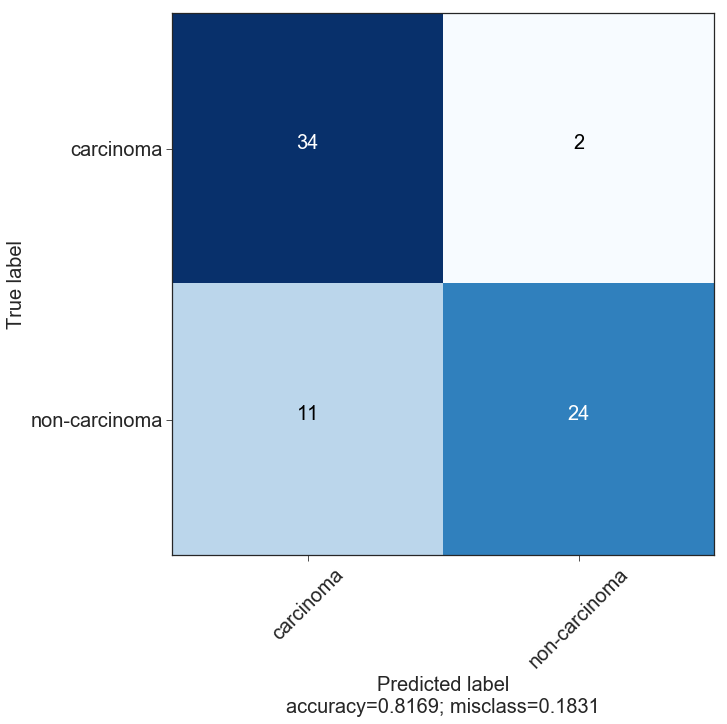

In [42]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [43]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[34  2]
 [11 24]]
               precision    recall  f1-score   support

    carcinoma       0.76      0.94      0.84        36
non-carcinoma       0.92      0.69      0.79        35

    micro avg       0.82      0.82      0.82        71
    macro avg       0.84      0.82      0.81        71
 weighted avg       0.84      0.82      0.81        71



In [44]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  75.55555555555556
Specificity :  92.3076923076923


In [45]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.8393162393162393


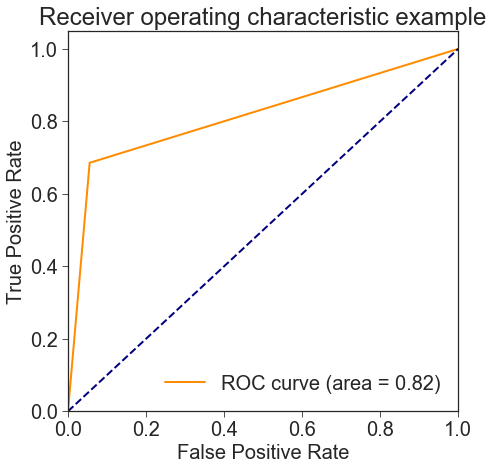

In [46]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [47]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

71/71 [==============================] - 0s 98us/step


In [48]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [49]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

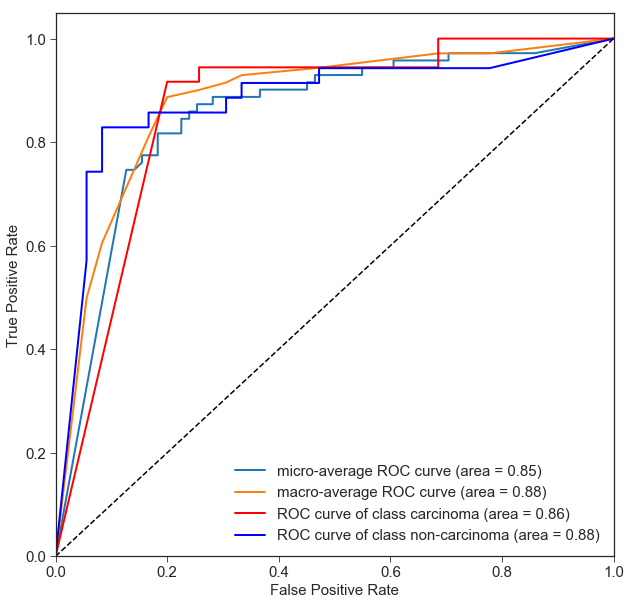

In [50]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [51]:
tn, fp, fn, tp = cm.ravel()

In [52]:
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn)

Accuracy: 0.8169014084507042
Precision: 0.9230769230769231
Recall: 0.6857142857142857
tp: 24
fp: 2
tn: 34
fn: 11


In [53]:
print('F1 score:', f1_score(y_true, y_pred))

F1 score: 0.7868852459016394


In [54]:
recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.7868852459016394


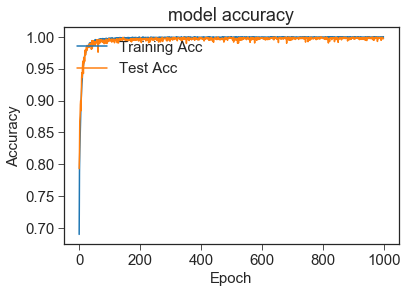

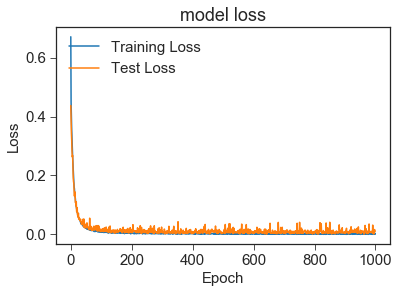

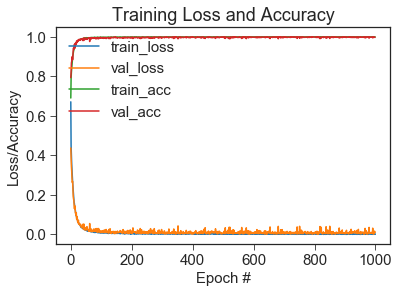

In [55]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")